Objectives:
Build classification machine learning to predict customer churn.

Succes Criteria:

Using recall to determine the best model. Because in the case of customer churn, the resulting model must be able to minimize False Negatives (FN) in order to reduce the probability of customer churn that is wrongly predicted to not churn which has the potential to harm the company because it loses customers without taking precautions.



# Import Data


In [ ]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('drive/My Drive/Challenge2_Binar Academy/train.csv')
test=pd.read_csv('drive/My Drive/Challenge2_Binar Academy/test.csv')

In [ ]:
train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [ ]:
test.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


# Understand and Clean Data

In [ ]:
train.shape

(4250, 20)

In [ ]:
# Data overview
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [ ]:
def train_info():
# Continuous data outliers using IQR
    continuous_train = train.select_dtypes(include=[float, int])
    Q1 = continuous_train.quantile(0.25)
    Q3 = continuous_train.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((continuous_train < (Q1 - 1.5 * IQR)) | (continuous_train > (Q3 + 1.5 * IQR))).sum()
    outliers = outliers.to_frame(name='outliers')
    
    # Summary stats for continuous data
    descr = continuous_train.describe().T

     # Nulls, data types, and unique values
    nulls = train.isna().sum().to_frame(name='nulls')
    dtypes = train.dtypes.to_frame(name='dtype')
    nuniques = train.nunique().to_frame(name='nunique')
    info = pd.concat([nulls, dtypes, nuniques], axis=1)
    
    # Left join continuous data
    info = info.merge(outliers, left_index=True, right_index=True, how='left')
    info = info.merge(descr, left_index=True, right_index=True, how='left')
    return info

train_info()

,nulls,dtype,nunique,outliers,count,mean,std,min,25%,50%,75%,max
state,0,object,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
account_length,0,int64,215,20.0,4250.0,100.236235,39.698401,1.0,73.0000,100.00,127.0000,243.00
area_code,0,object,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
international_plan,0,object,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
voice_mail_plan,0,object,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_vmail_messages,0,int64,46,86.0,4250.0,7.631765,13.439882,0.0,0.0000,0.00,16.0000,52.00
total_day_minutes,0,float64,1843,25.0,4250.0,180.259600,54.012373,0.0,143.3250,180.45,216.2000,351.50
total_day_calls,0,int64,120,28.0,4250.0,99.907294,19.850817,0.0,87.0000,100.00,113.0000,165.00
total_day_charge,0,float64,1843,26.0,4250.0,30.644682,9.182096,0.0,24.3650,30.68,36.7500,59.76
total_eve_minutes,0,float64,1773,34.0,4250.0,200.173906,50.249518,0.0,165.9250,200.70,233.7750,359.30


In [ ]:
# Checking missing value
train.isna().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [ ]:
# Checking duplicate data
print(train.duplicated().sum())

0


In [ ]:
# Chekinng the data types of all the columns
train.dtypes

state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object

In [ ]:
for item in train.columns:
    print(item)
    print (train[item].unique())

state
['OH' 'NJ' 'OK' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY' 'ID' 'VA'
 'TX' 'FL' 'CO' 'AZ' 'SC' 'WY' 'HI' 'NH' 'AK' 'GA' 'MD' 'AR' 'WI' 'OR'
 'MI' 'DE' 'UT' 'CA' 'SD' 'NC' 'WA' 'MN' 'NM' 'NV' 'DC' 'VT' 'KY' 'ME'
 'MS' 'AL' 'NE' 'KS' 'TN' 'IL' 'PA' 'CT' 'ND']
account_length
[107 137  84  75 121 147 117 141  65  74 168  95 161  85  76  73  77 130
 111 132  57  54  20  49  12  36  78 136  98 135  34 160  64  59 142  97
  52  60  10  96  81 125 174 116 149  38  40  43 113 126 150 138 162  90
  50  82 144  46  70 128  94 155  80  99 120 108 122  93 157  63  41 193
  61  92 163  91 127 110 103 145  56 151  83 139   6 115  62 185 148  32
  68  25 179  67  19 170 106  51 118 208 131  53 105  66  35  88 123  45
 100 215  22  33  86 114  24 119 101 146 143  48 167  89 199 166 158 196
 112 209  16  39 104 129  55  44  79 159 194  87  21 133 224 140  58 109
  71  72 124 102 165  18  30 190  47 152  26  69  31 186 171  28 153 172
 169  13 189 176 156  37  27 134 243  42  23   1 200   5 178 1

In [ ]:
# Convert all yes to 1 and no to 0 in train
columns_to_convert = ['international_plan', 
                      'voice_mail_plan',  
                      'churn']

for item in columns_to_convert:
    train[item].replace(to_replace='yes', value=1, inplace=True)
    train[item].replace(to_replace='no',  value=0, inplace=True)
train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,NJ,137,area_code_415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
2,OH,84,area_code_408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
3,OK,75,area_code_415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
4,MA,121,area_code_510,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0


In [ ]:
# Convert all yes to 1 and no to 0 in test
columns_to_convert = ['international_plan', 
                      'voice_mail_plan']

for item in columns_to_convert:
    test[item].replace(to_replace='yes', value=1, inplace=True)
    test[item].replace(to_replace='no',  value=0, inplace=True)
test.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,0,0,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,0,0,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


# Exploratory Data Analysis (EDA)

In [ ]:
import matplotlib.ticker as mtick # For specifying the axes tick format 
import seaborn as sns

### Churn Proportion

14.1% of customers churn


0    3652
1     598
Name: churn, dtype: int64

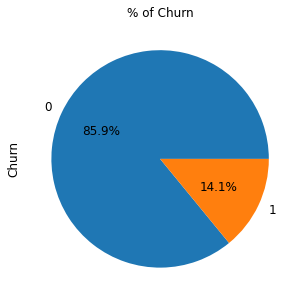

In [ ]:
# Check for 'Churn' class imbalance
ax = (train['churn'].value_counts()*100.0 /len(train))\
.plot.pie(autopct='%.1f%%', labels = ['0', '1'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Churn',fontsize = 12)
ax.set_title('% of Churn', fontsize = 12)

pct_churn = (train['churn'].value_counts(normalize=True).loc[1]* 100)
print(f'{pct_churn:.1f}% of customers churn')
train['churn'].value_counts()

### Check Correlation

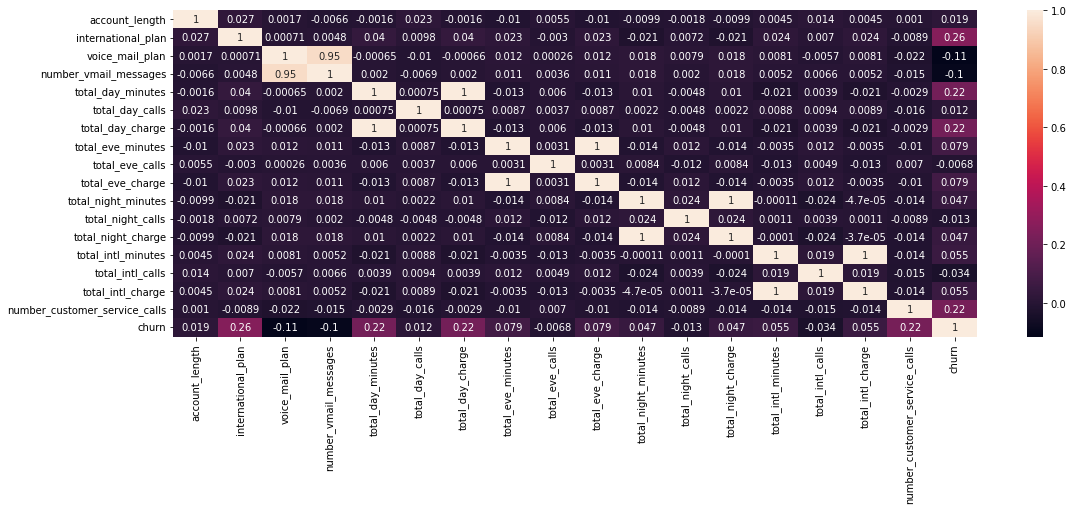

In [ ]:
# Check Correlation

plt.figure(figsize=(18,6))
sns.heatmap(train.corr(),annot=True)
plt.show()

### Churn & Area Code

In [ ]:
# Churn & Area Code

area_by_churn = train.groupby('area_code')['churn'].value_counts(normalize=True).to_frame()
area_by_churn.columns = ['Proportion']
area_by_churn.reset_index(inplace=True)

In [ ]:
pvt_abc=area_by_churn.pivot(columns='churn', index='area_code', values='Proportion')
pvt_abc

churn,0,1
area_code,,
area_code_408,0.860037,0.139963
area_code_415,0.863852,0.136148
area_code_510,0.849432,0.150568


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

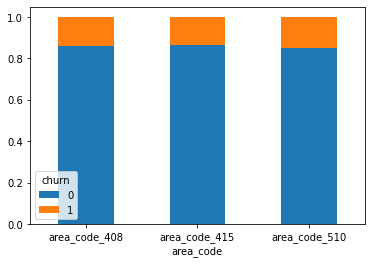

In [ ]:
pvt_abc.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)

the difference in the proportion of churn in each code area is small. So Area code has no effect on churn.

### Churn & Account Length

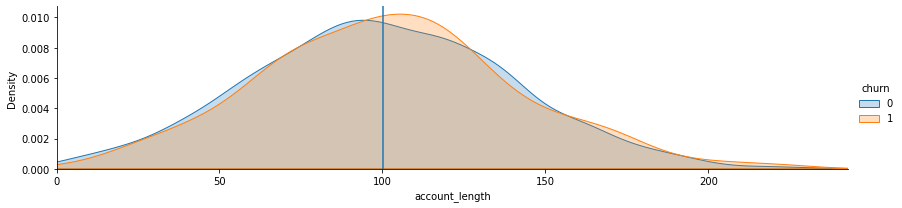

In [ ]:
# Churn & Account Length
facet = sns.FacetGrid(train, hue="churn",aspect=4)
facet.map(sns.kdeplot,'account_length', shade=True)
facet.set(xlim=(0, train['account_length'].max()))
plt.axvline(train['account_length'].mean())
facet.add_legend()

### Churn & State

In [ ]:
# State have most number of churn

state_by_class = train.groupby('state')['churn'].value_counts(normalize=True).to_frame()
state_by_class.columns = ['Proportion']
state_by_class.reset_index(inplace=True)


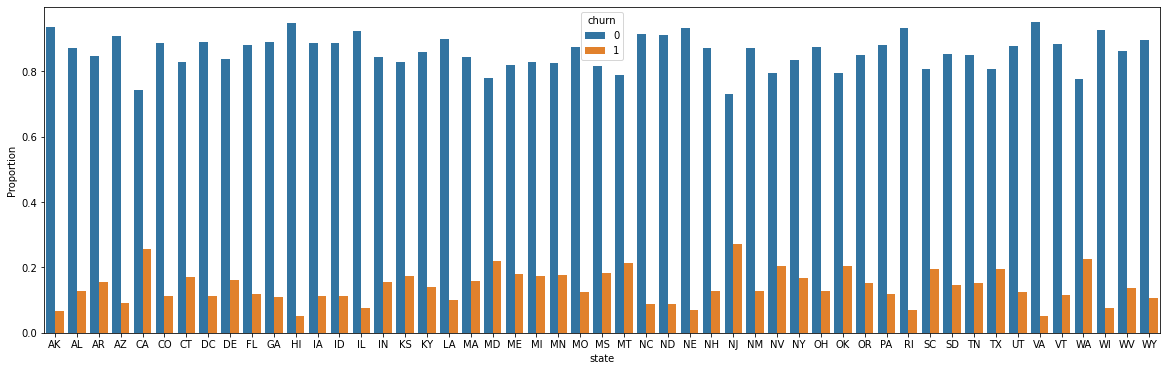

In [ ]:
plt.figure(figsize=(20,6))

sns.barplot(data = state_by_class, hue = 'churn', x='state', y='Proportion')

In [ ]:
pvt_sbc=state_by_class.pivot(columns='churn', index='state', values='Proportion')
pvt_sbc

churn,0,1
state,,
AK,0.934426,0.065574
AL,0.871287,0.128713
AR,0.845070,0.154930
AZ,0.909091,0.090909
CA,0.743590,0.256410
CO,0.887500,0.112500
CT,0.829545,0.170455
DC,0.888889,0.111111
DE,0.837500,0.162500


Most Churn is in NJ and CA states.

### Churn & International Plan

In [ ]:
# International plan VS Churn

international_by_churn = train.groupby('international_plan')['churn'].value_counts(normalize=True).to_frame()
international_by_churn.columns = ['Proportion']
international_by_churn.reset_index(inplace=True)


In [ ]:
pvt_ibc=international_by_churn.pivot(columns='churn', index='international_plan', values='Proportion')
pvt_ibc

churn,0,1
international_plan,,
0,0.888168,0.111832
1,0.578283,0.421717


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

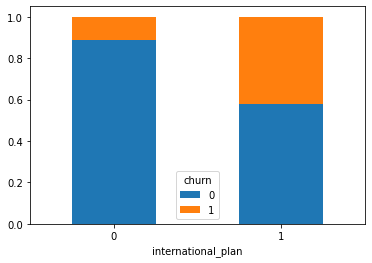

In [ ]:
pvt_ibc.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)

### Voice Mail & Churn

In [ ]:
# Voice mail plan VS Churn

voice_by_churn = train.groupby('voice_mail_plan')['churn'].value_counts(normalize=True).to_frame()
voice_by_churn.columns = ['Proportion']
voice_by_churn.reset_index(inplace=True)

In [ ]:
pvt_vbc=voice_by_churn.pivot(columns='churn', index='voice_mail_plan', values='Proportion')
pvt_vbc

churn,0,1
voice_mail_plan,,
0,0.835564,0.164436
1,0.926259,0.073741


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

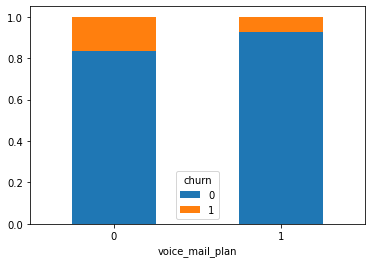

In [ ]:
pvt_vbc.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)

# Preprocessing

In [ ]:
# Drop state columns in data train
train.drop('state',axis=1,inplace=True)

In [ ]:
# One hot encoding data train untuk mengubah kategorikal menjadi numerikal

train = pd.get_dummies(train
                        , columns=['area_code']
                        , prefix={'area_code': 'area_code'}
                       )

In [ ]:
train.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510
0,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,103,11.45,13.7,3,3.70,1,0,0,1,0
1,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,104,7.32,12.2,5,3.29,0,0,0,1,0
2,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,89,8.86,6.6,7,1.78,2,0,1,0,0
3,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,121,8.41,10.1,3,2.73,3,0,0,1,0
4,121,0,1,24,218.2,88,37.09,348.5,108,29.62,...,118,9.57,7.5,7,2.03,3,0,0,0,1


In [ ]:
# Drop state columns in test data
test.drop('state',axis=1,inplace=True)

In [ ]:
# One hot encoding data test untuk mengubah kategorikal menjadi numerikal

test = pd.get_dummies(test
                        , columns=['area_code']
                        , prefix={'area_code': 'area_code'}
                       )

In [ ]:
test.head()

,id,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,...,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510
0,1,128,0,1,25,265.1,110,45.07,197.4,99,...,244.7,91,11.01,10.0,3,2.70,1,0,1,0
1,2,118,1,0,0,223.4,98,37.98,220.6,101,...,203.9,118,9.18,6.3,6,1.70,0,0,0,1
2,3,62,0,0,0,120.7,70,20.52,307.2,76,...,203.0,99,9.14,13.1,6,3.54,4,0,1,0
3,4,93,0,0,0,190.7,114,32.42,218.2,111,...,129.6,121,5.83,8.1,3,2.19,3,0,0,1
4,5,174,0,0,0,124.3,76,21.13,277.1,112,...,250.7,115,11.28,15.5,5,4.19,3,0,1,0


In [ ]:
# Drop target variable

X = train.drop('churn', axis=1)
Y = train['churn']
X.shape, Y.shape

((4250, 20), (4250,))

# Modeling

### Train-test split

In [ ]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=.25, stratify=Y, random_state=7)

### Logistic Regression Model

In [ ]:
# Logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
# Accuracy evaluation
accuracy_regression=accuracy_score(Y_test, logreg.predict(X_test))
print("Accuracy: %.3f%%" % (accuracy_regression*100.0))


Accuracy: 85.889%


In [ ]:
# Recall evaluation
recall_regression= recall_score(Y_test, logreg.predict(X_test))
print("Recall: %.3f%%" % (recall_regression*100.0))


Recall: 10.667%


In [ ]:
# AUC Evaluation

y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:,1]
AUC_regression = roc_auc_score(Y_test,y_pred_proba)
print("AUC of ROC: %.3f%%" % (AUC_regression*100.0))

AUC of ROC: 73.617%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


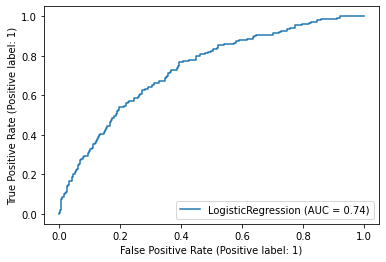

In [ ]:
plot_roc_curve(logreg, X_test, Y_test)

Now determine the recall value using AUC threshold value.

In [ ]:
pred_proba_logreg = logreg.predict_proba(X_test)

In [ ]:
fpr, tpr, threshold = roc_curve(Y_test, pred_proba_logreg[:,1])

In [ ]:
roc_df = pd.DataFrame()
roc_df['fpr'] = fpr
roc_df['tpr'] = tpr
roc_df['threshold'] = threshold
roc_df[(roc_df['tpr']>0.6)].sort_values('tpr', ascending=False)

,fpr,tpr,threshold
230,1.000000,1.000000,0.004304
229,0.921139,1.000000,0.024786
228,0.921139,0.993333,0.024861
227,0.912377,0.993333,0.026682
226,0.912377,0.986667,0.027049
...,...,...,...
136,0.281490,0.626667,0.164258
133,0.271632,0.620000,0.167699
134,0.272727,0.620000,0.166793
132,0.271632,0.606667,0.169021


In [ ]:
thres_logreg = 0.170391
pred_017 = np.where(pred_proba_logreg[:,1]>thres_logreg, 1, 0)

In [ ]:
accuracy_tresh_logreg=accuracy_score(Y_test, pred_017)
print("Accuracy: %.3f%%" % (accuracy_tresh_logreg*100.0))

Accuracy: 71.778%


In [ ]:
recall_tresh_logreg=recall_score(Y_test, pred_017)
print("Recall: %.3f%%" % (recall_tresh_logreg*100.0))

Recall: 60.667%


The recall value from the threshold increased to 60.667%

### Gaussian Naive Bayes

In [ ]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)


GaussianNB()

In [ ]:
# Accuracy evaluation

accuracy_gaussian=accuracy_score(Y_test, gaussian.predict(X_test))
print("Accuracy Bayes: %.3f%%" % (accuracy_gaussian*100.0))

Accuracy Bayes: 86.548%


In [ ]:
# Recall evaluation

recall_gaussian= recall_score(Y_test, gaussian.predict(X_test))
print("Recall: %.3f%%" % (recall_gaussian*100.0))

Recall: 48.000%


In [ ]:
# AUC evaluation

y_pred_gaussian = gaussian.predict(X_test)
y_pred_gaussian_proba= gaussian.predict_proba(X_test)[:,1]
AUC_gaussian= roc_auc_score(Y_test,y_pred_gaussian_proba)
print("AUC of ROC: %.3f%%" % (AUC_gaussian*100.0))

AUC of ROC: 81.535%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


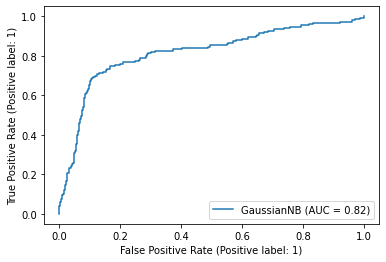

In [ ]:
plot_roc_curve(gaussian, X_test, Y_test)

In [ ]:
pred_proba_gaussian = gaussian.predict_proba(X_test)

In [ ]:
fpr, tpr, threshold = roc_curve(Y_test, pred_proba_gaussian[:,1])

In [ ]:
roc_df = pd.DataFrame()
roc_df['fpr'] = fpr
roc_df['tpr'] = tpr
roc_df['threshold'] = threshold
roc_df[(roc_df['tpr']>0.7)].sort_values('tpr', ascending=False)

,fpr,tpr,threshold
196,1.000000,1.000000,0.000022
195,1.000000,0.993333,0.000037
194,0.986857,0.993333,0.000115
193,0.986857,0.986667,0.000126
192,0.972618,0.986667,0.000227
...,...,...,...
113,0.152245,0.720000,0.187887
110,0.129244,0.713333,0.224330
111,0.142388,0.713333,0.206819
109,0.129244,0.706667,0.225294


In [ ]:
tresh_gaussian=0.233833
pred_023 = np.where(pred_proba_gaussian[:,1]>tresh_gaussian, 1, 0)

In [ ]:
accuracy_tresh_gaussian=accuracy_score(Y_test, pred_023)
print("Accuracy: %.3f%%" % (accuracy_tresh_gaussian*100.0))

Accuracy: 85.136%


In [ ]:
recall_tresh_gaussian=recall_score(Y_test, pred_023)
print("Recall: %.3f%%" % (recall_tresh_gaussian*100.0))

Recall: 70.667%


Recall value of Gaussian results increased to 70.667%

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(max_depth=4)
rfc.fit(X_train, Y_train)

RandomForestClassifier(max_depth=4)

In [ ]:
# Accuracy Evaluation
accuracy_rfc=accuracy_score(Y_test, rfc.predict(X_test))
print("Accuracy: %.3f%%" % (accuracy_rfc*100.0))

Accuracy: 89.370%


In [ ]:
# Recall Evaluation
recall_rfc=recall_score(Y_test, rfc.predict(X_test))
print("Recall: %.3f%%" % (recall_rfc*100.0))

Recall: 26.000%


In [ ]:
# AUC evaluation

y_pred_rfc = rfc.predict(X_test)
y_pred_rfc_proba= rfc.predict_proba(X_test)[:,1]
AUC_rfc= roc_auc_score(Y_test,y_pred_rfc_proba)
print("AUC of ROC: %.3f%%" % (AUC_rfc*100.0))

AUC of ROC: 88.656%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


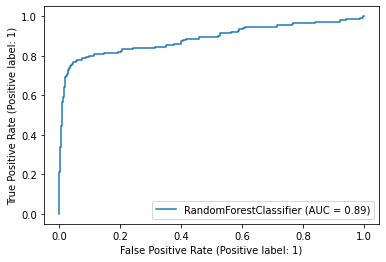

In [ ]:
plot_roc_curve(rfc, X_test, Y_test)

In [ ]:
pred_proba_rfc = rfc.predict_proba(X_test)

In [ ]:
fpr, tpr, threshold = roc_curve(Y_test, pred_proba_rfc[:,1])

In [ ]:
roc_df = pd.DataFrame()
roc_df['fpr'] = fpr
roc_df['tpr'] = tpr
roc_df['threshold'] = threshold
roc_df[(roc_df['tpr']>0.8)].sort_values('tpr', ascending=False)

,fpr,tpr,threshold
130,1.000000,1.000000,0.043164
129,0.998905,1.000000,0.043300
128,0.998905,0.993333,0.043480
127,0.986857,0.993333,0.044567
126,0.986857,0.986667,0.044623
...,...,...,...
66,0.192771,0.820000,0.106813
64,0.145674,0.813333,0.150453
65,0.192771,0.813333,0.107363
63,0.145674,0.806667,0.153348


In [ ]:
tresh_rfc=0.163078
pred_0163 = np.where(pred_proba_rfc[:,1]>tresh_rfc, 1, 0)

In [ ]:
accuracy_tresh_rfc=accuracy_score(Y_test, pred_0163)
print("Accuracy: %.3f%%" % (accuracy_tresh_rfc*100.0))

Accuracy: 85.230%


In [ ]:
recall_tresh_rfc=recall_score(Y_test, pred_0163)
print("Recall: %.3f%%" % (recall_tresh_rfc*100.0))

Recall: 80.667%


Recall value increased to 80.667%.



# Pemilihan model

Model selection:

The highest recall value is shown in the random forest model. So the random forest model was chosen to predict customer churn.

# Churn prediction using best model (random forest)

In [ ]:
prediksi = np.where(pred_proba_rfc[:,1]>tresh_rfc, 1, 0)

In [ ]:
# Hasil test

df_prediksi = pd.DataFrame(prediksi, columns=['churn'])
df_prediksi.value_counts()

churn
0        814
1        249
dtype: int64

Text(0.5, 1.0, '% of Churn')

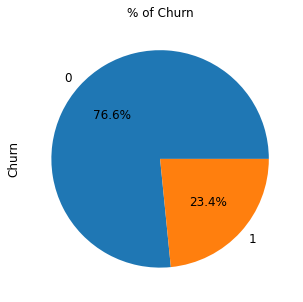

In [ ]:
prediksi_churn = (df_prediksi['churn'].value_counts()*100.0 /len(df_prediksi))\
.plot.pie(autopct='%.1f%%', labels = ['0', '1'],figsize =(5,5), fontsize = 12 )                                                                           
prediksi_churn.yaxis.set_major_formatter(mtick.PercentFormatter())
prediksi_churn.set_ylabel('Churn',fontsize = 12)
prediksi_churn.set_title('% of Churn', fontsize = 12)
